# Gradient-Domain Copy Paste

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

In [2]:
def least_squares_2D(im_s, im_background):
    #### initialize results to just be copies of the background
    im_blend = im_background.copy()
    
    #### initialize the size of source image 
    imh, imw = (im_s.shape[0], im_s.shape[1])    #### imh: image hight, imw: image width
    imd = 1 if im_s.ndim < 3 else im_s.shape[2]  #### number of components of each pixel, e.g., for an RGB image, imd=3
    
    num_vars = (imh - 2) * (imw - 2)
    num_eqns = (imh - 1) * (imw - 2) + (imh - 2) * (imw - 1)
    
    # create matrix
    im2var = np.zeros((imh,imw), dtype=int)
    # create indices for pixels
    indices = np.arange(0, num_vars)
    # reshape into 2d matrix
    inner_mat = indices.reshape((imh-2, imw-2))
    # assign coordinates inside 1 pixel padding
    im2var[1:-1,1:-1] = inner_mat
    
    #### check if the mapping is initialized correctly
    print(f"im2var:\n{im2var}")
    
    #### initialize A and b ####
    A = lil_matrix((num_eqns, num_vars))
    b = np.zeros((num_eqns, imd))
    
    row = 0
    
    # vertical constraints
    for i in range(1,imw-1):
        # first constraint
        A[row,im2var[1,i]] = 1
        b[row] = im_s[1,i] - im_s[0,i] + im_background[0,i]
        row+=1
        
        # last constraint
        A[row, im2var[-2, i]] = -1
        b[row] = im_s[-1,i] - im_s[-2, i] - im_background[-1,i]
        row+=1
        
        # constraints not on edges
        for j in range(2,imh-1):
            A[row, im2var[j-1,i]] = -1
            A[row, im2var[j,i]] = 1
            b[row] = im_s[j,i] - im_s[j-1,i]
            row+=1
            
    
    # horizontal constraints
    for i in range(1,imh-1):
        # first constraint
        A[row,im2var[i,1]] = 1
        b[row] = im_s[i,1] - im_s[i,0] + im_background[i,0]
        row+=1
        
        # last constraint
        A[row, im2var[i, -2]] = -1
        b[row] = im_s[i,-1] - im_s[i, -2] - im_background[i,-1]
        row+=1
        
        # constraints not on edges
        for j in range(2,imw-1):
            A[row, im2var[i,j-1]] = -1
            A[row, im2var[i,j]] = 1
            b[row] = im_s[i,j] - im_s[i,j-1]
            row+=1
    
    #### solve the least-squares problem
    #### convert A to (CSR) sparse format
    A = A.tocsr()
    
    print('Solving sparse system using sla.lsqr...')
    t = time.time()

    #### solve for all channels
    for c in range(0,imd):
        v = sla.lsqr(A,b[:,c])[0]
        #### copy over to im_blend
        if im_s.ndim > 2: #### this branch is for rgb image
            im_blend[1:-1, 1:-1, c] = v.reshape((imh-2, imw-2))
            
        else:  #### this branch is for gray-scale image     
            im_blend[1:-1, 1:-1] = v.reshape((imh-2),(imw-2))
    
    elapsed = time.time() - t
    print("\tTotal time for sparse solve: {} seconds \n".format(elapsed))

    #### return the blended result
    return im_blend

### Testing `least_squares_2D`

Test Case 1: Before testing `least_squares_2D` on a larger image, test it on the 4 x 4 `source_im` and `background_im` from the simple 2D section in the code block below.

im2var:
[[0 0 0 0]
 [0 0 1 0]
 [0 2 3 0]
 [0 0 0 0]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.0003268718719482422 seconds 



<IPython.core.display.Javascript object>


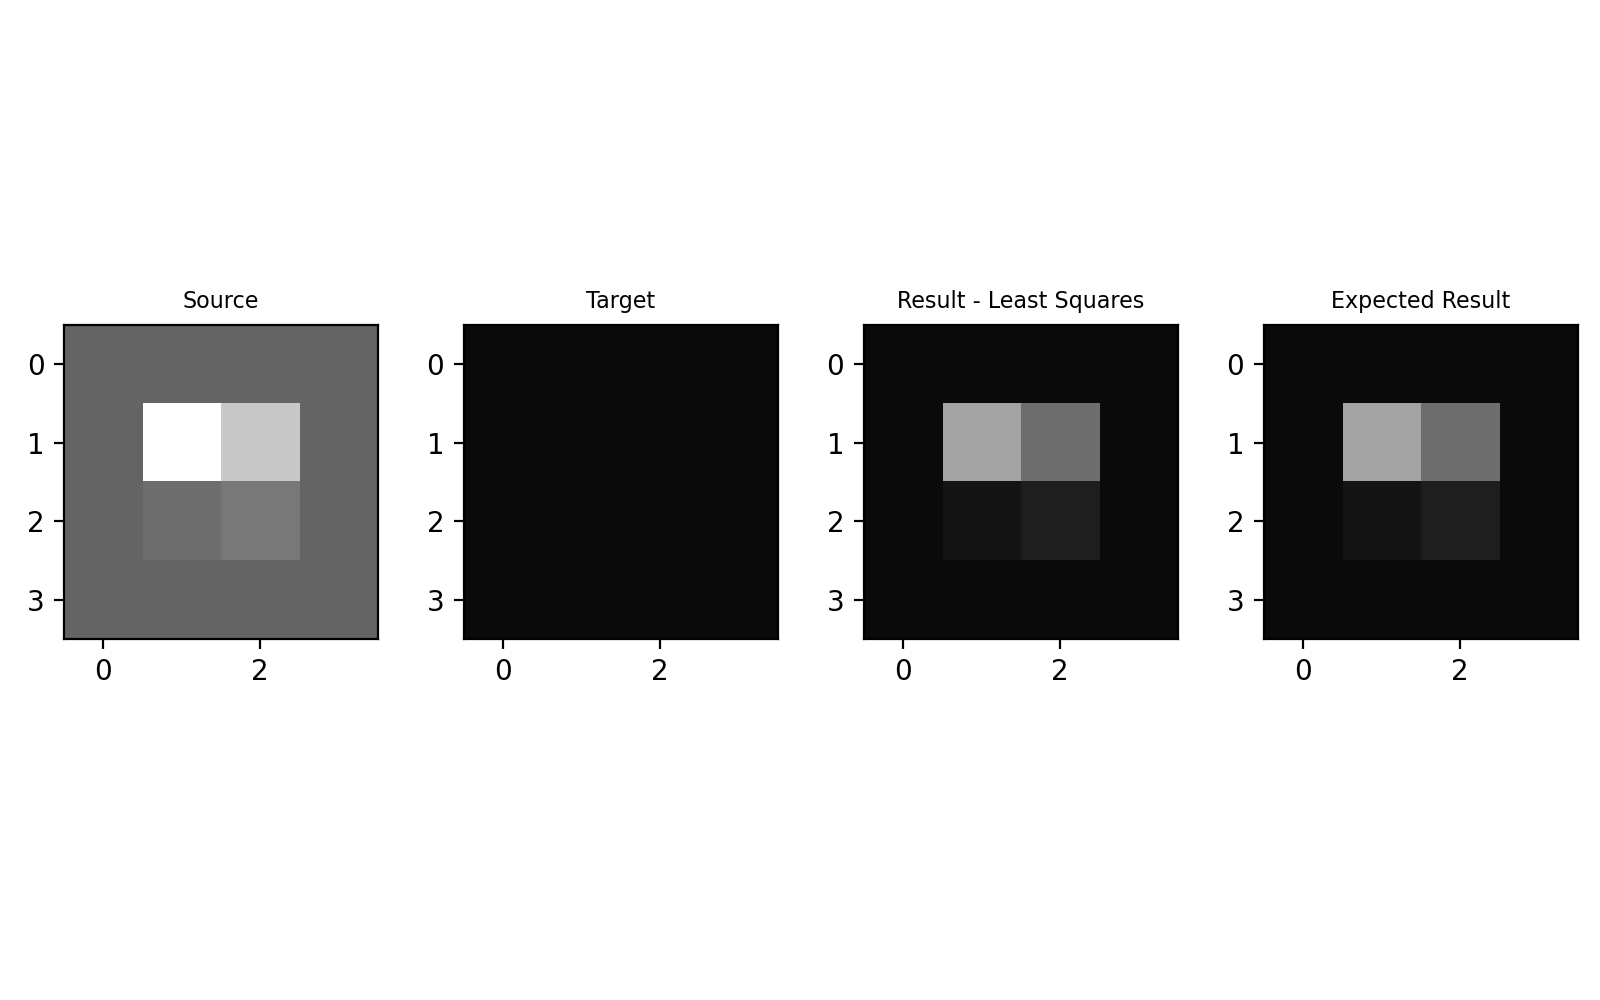

In [3]:
expected = np.array([[ 10,  10,  10,  10],
                     [ 10, 164, 110,  10],
                     [ 10,  20,  30,  10],
                     [ 10,  10,  10,  10]])

source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 200, 100],
                          [100, 110, 120, 100],
                          [100, 100, 100, 100]])
background_im = np.array([[10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10]])

# call least_squares_2D on source_im, background_im
# display source, target, sla.lsqr output, normal equation output, expected output

# simple paste of 2x2 square onto 4x4 square
size = 4
im_out = least_squares_2D(source_im, background_im)

fig, axs = plt.subplots(1,4)
fig.set_size_inches(8,5)
fig.tight_layout(pad=0.0)

#### draw source_im
axs[0].imshow(source_im, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Source', fontsize=8)
axs[0].set_yticks(np.arange(0, size))

#### draw background_im
axs[1].imshow(background_im, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Target', fontsize=8)
axs[1].set_yticks(np.arange(0, size))

#### draw your result after calling least_squares_2D
axs[2].imshow(im_out, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Result - Least Squares', fontsize=8)
axs[2].set_yticks(np.arange(0, size))

#### draw the expected result
axs[3].imshow(expected, cmap='gray', vmin=0, vmax=255)
axs[3].set_title('Expected Result', fontsize=8)
axs[3].set_yticks(np.arange(0, size))

plt.show()

im2var:
[[    0     0     0 ...     0     0     0]
 [    0     0     1 ...   106   107     0]
 [    0   108   109 ...   214   215     0]
 ...
 [    0 12420 12421 ... 12526 12527     0]
 [    0 12528 12529 ... 12634 12635     0]
 [    0     0     0 ...     0     0     0]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.08627033233642578 seconds 



<IPython.core.display.Javascript object>


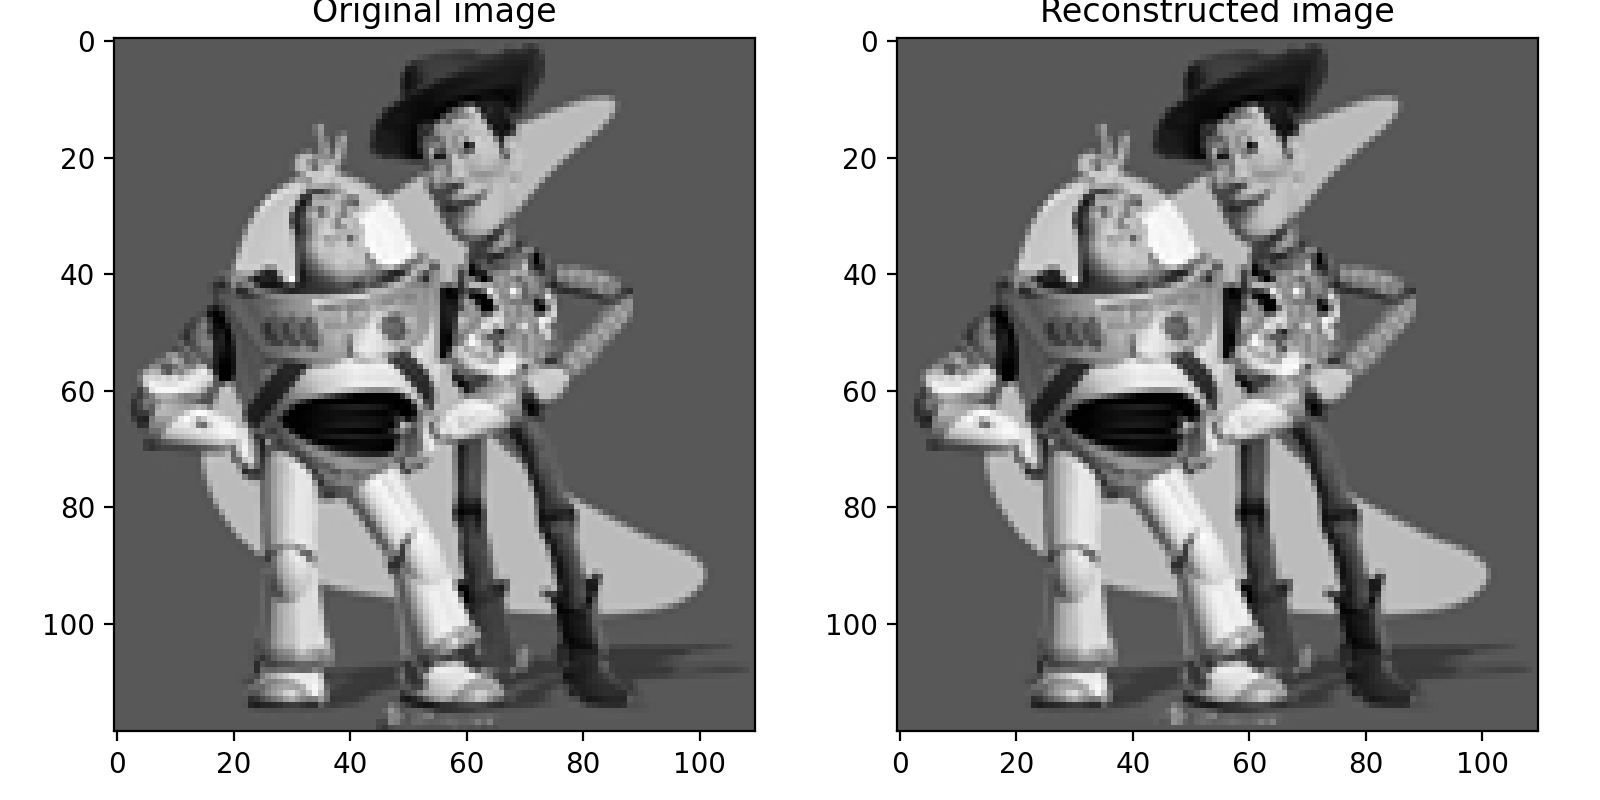

Error: 2.638464259955608e-05


In [4]:
toyim = plt.imread('images/toy_problem.png')
im_background = np.full(toyim.shape, toyim[0, 0])

im_out = least_squares_2D(toyim, im_background)

# show the original image
fig2, axs2 = plt.subplots(1,2)
fig2.tight_layout(pad=1.0)
fig2.set_size_inches(8,4)

axs2[0].imshow(toyim, cmap = plt.cm.gray)
axs2[0].set_title("Original image")
    
# show the reconstruction
axs2[1].imshow(im_out, cmap = plt.cm.gray)
axs2[1].set_title("Reconstructed image")  

print('Error: {error}'.format(error=np.linalg.norm(im_out - toyim)/(toyim.size)))
plt.show()

## Poisson Blending

<IPython.core.display.Javascript object>


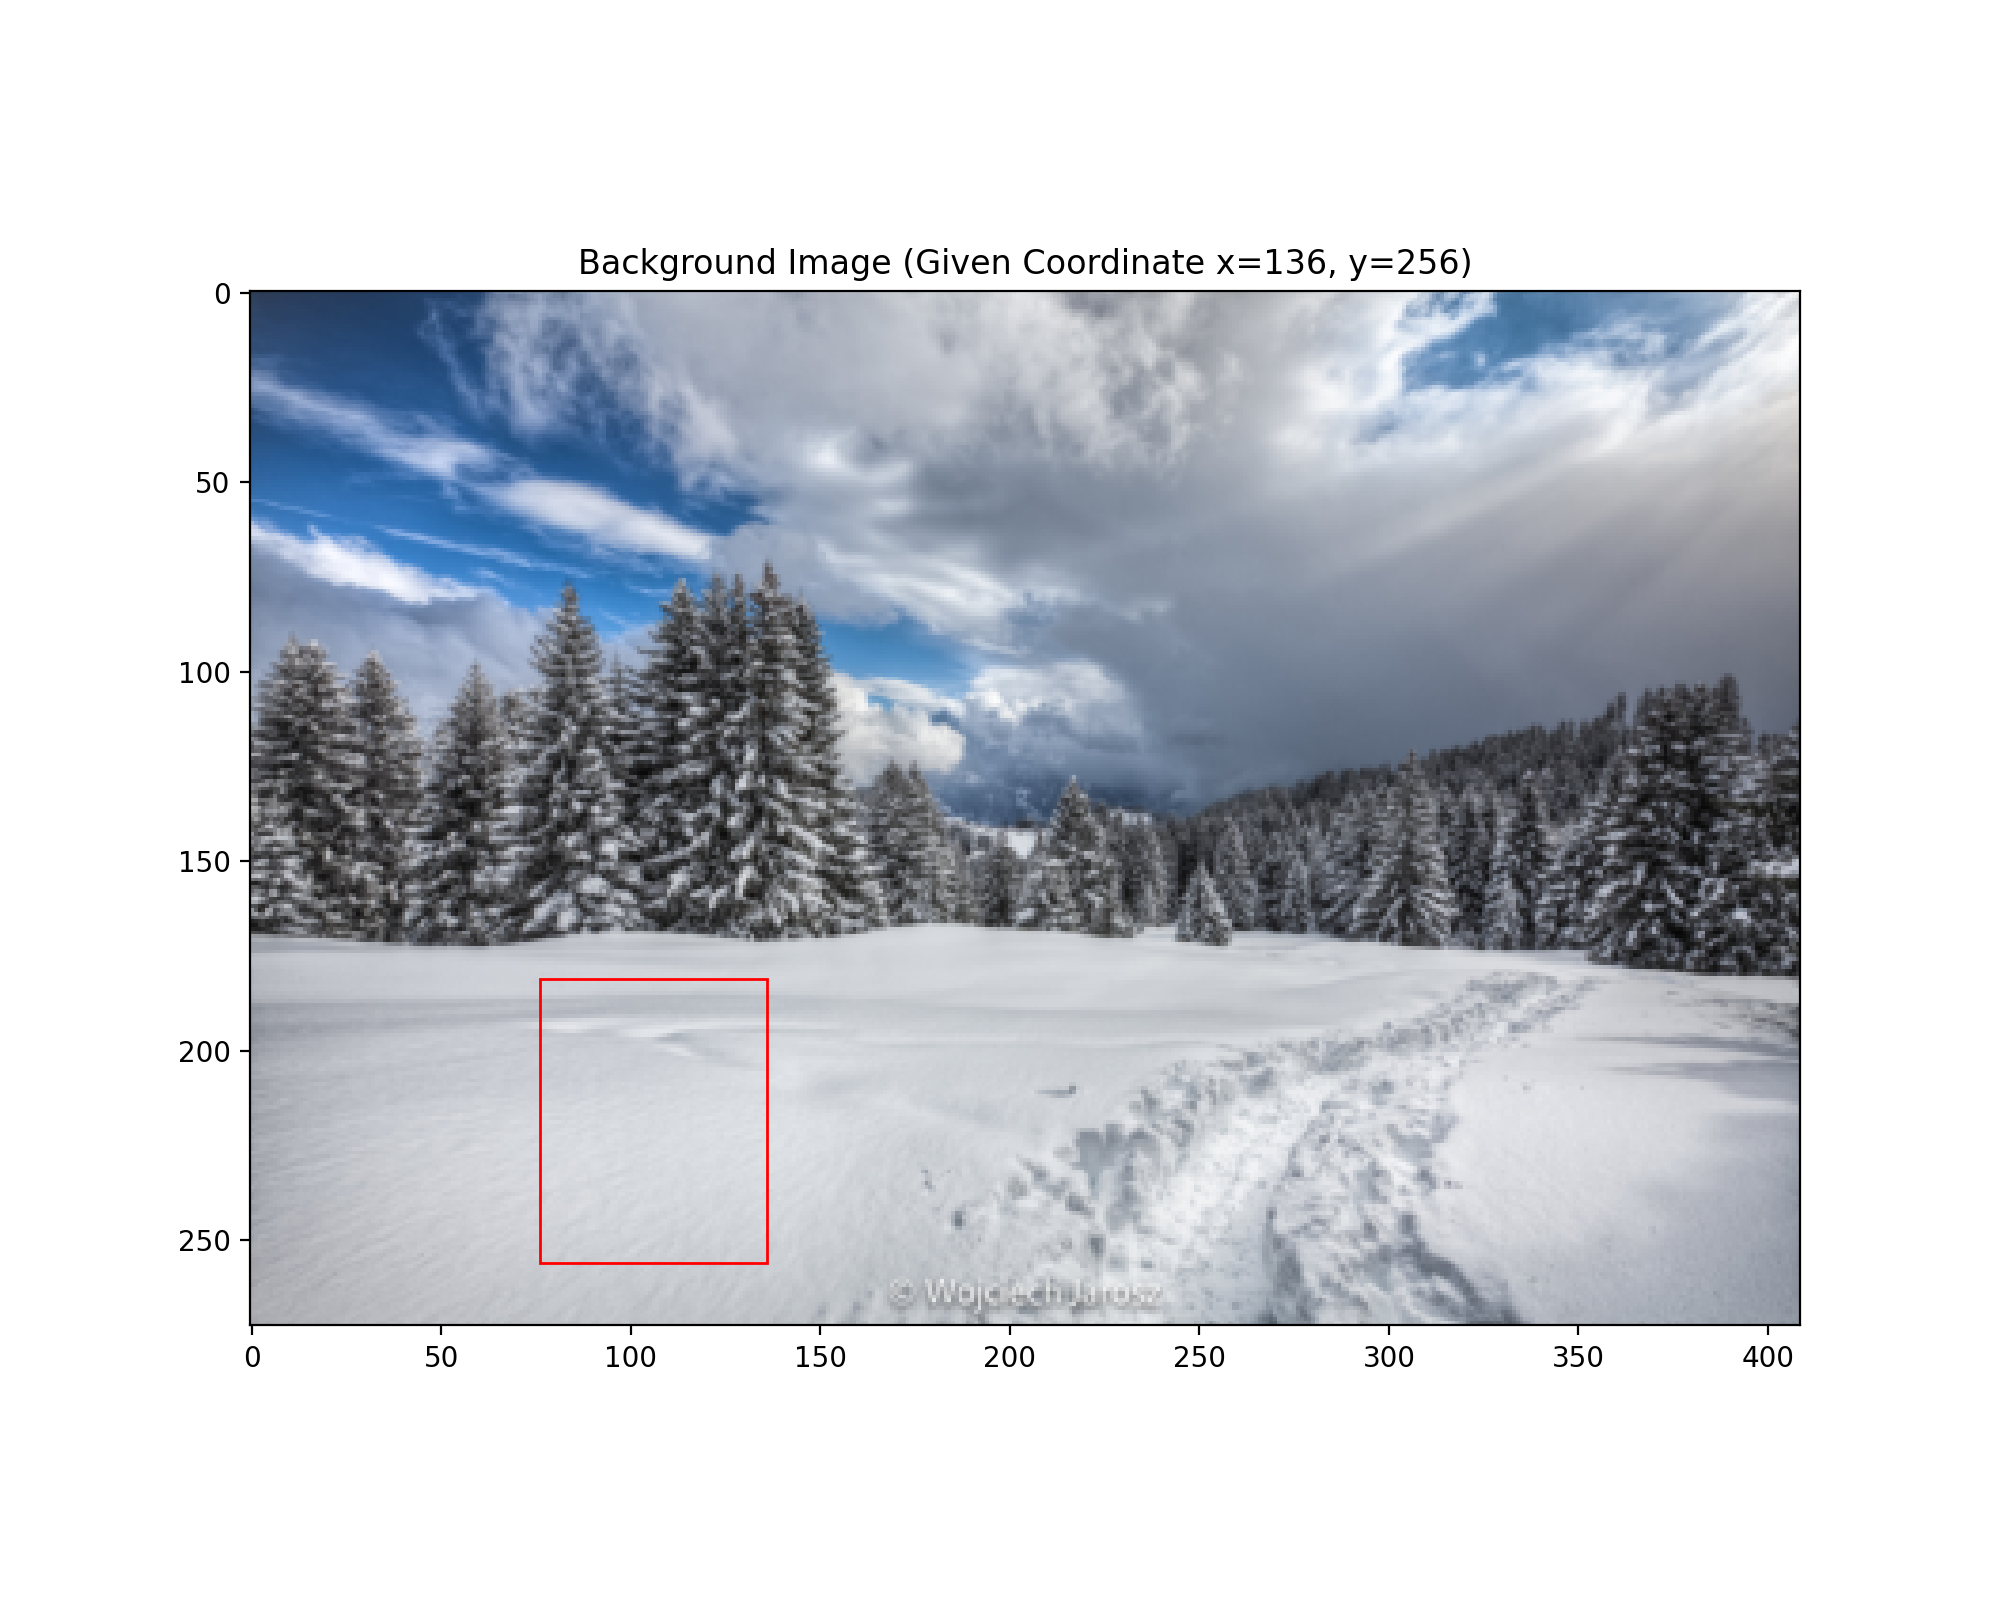

In [5]:
## new gradient domain copy-paste code should go here
# read in background and object images
im_background = plt.imread('images/background.jpg')/255.0
im_object = plt.imread('images/penguin-chick.jpg')/255.0
#
# reduce the size of the image for faster performance while debugging
# You can comment these two lines out to use the full-resolution images
im_background = resize(im_background, (im_background.shape[0] // 5,
                                       im_background.shape[1] // 5),
                       anti_aliasing=True)
im_object = resize(im_object, (im_object.shape[0] // 5,
                               im_object.shape[1] // 5),
                       anti_aliasing=True)

# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.array([136, 256])  

fig = plt.figure()
# draw rectangle on image
rect = Rectangle((coords[0]-objw,coords[1]-objh), objw, objh,linewidth=1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)

fig.set_size_inches(10,8)
plt.imshow(im_background)

plt.title(f"Background Image (Given Coordinate x={coords[0]}, y={coords[1]})")
plt.show()

In [6]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape

    res = im_background.copy()
    background = im_background[y-objh:y, x-objw:x, :]
    res[y-objh:y, x-objw:x, :] = least_squares_2D(im_object, background)
    
    return res

<IPython.core.display.Javascript object>


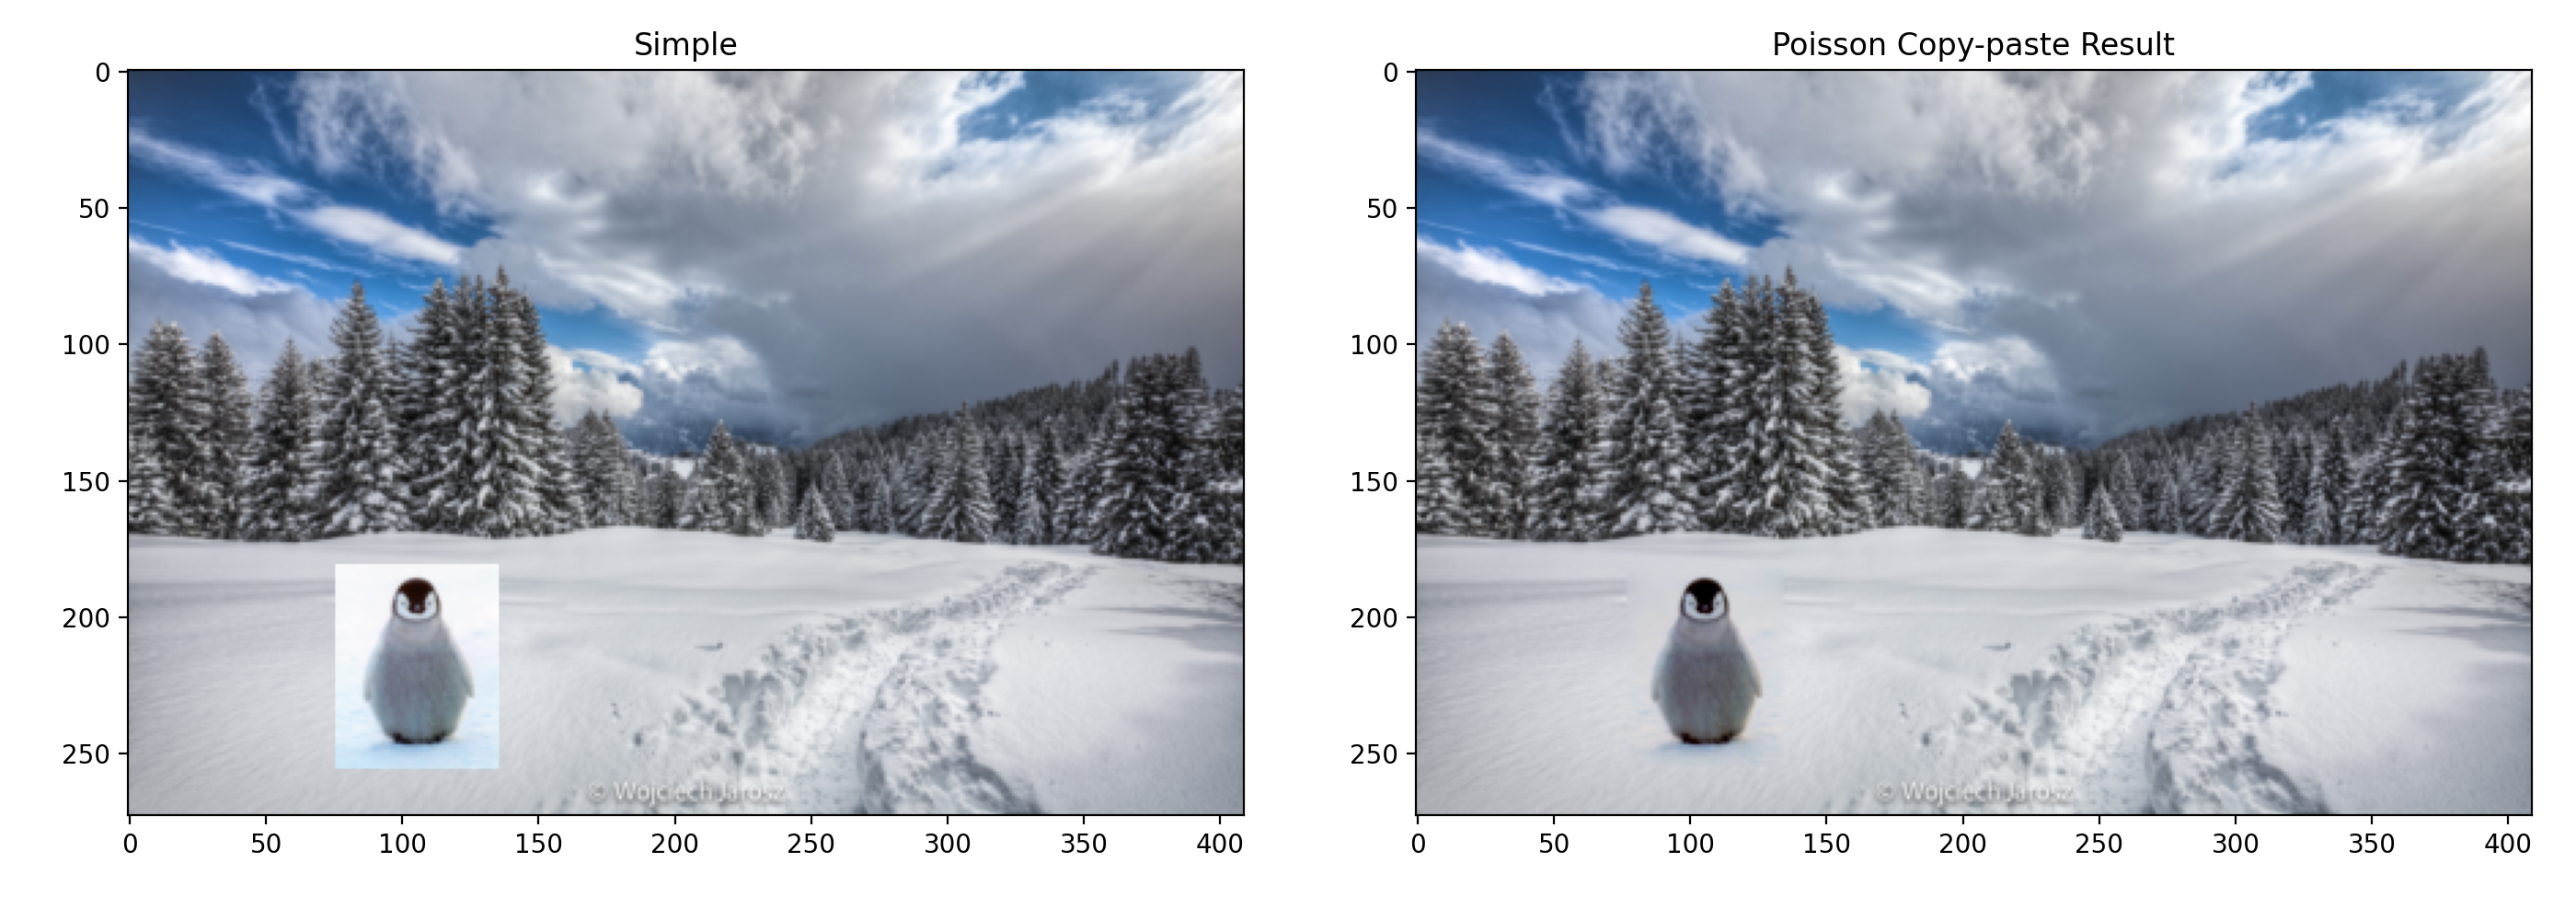

im2var:
[[   0    0    0 ...    0    0    0]
 [   0    0    1 ...   56   57    0]
 [   0   58   59 ...  114  115    0]
 ...
 [   0 4118 4119 ... 4174 4175    0]
 [   0 4176 4177 ... 4232 4233    0]
 [   0    0    0 ...    0    0    0]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.053292036056518555 seconds 



In [7]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig3, axs3 = plt.subplots(1,2)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple")

res1 = poisson_copy_paste(coords, im_object, im_background)
axs3[1].imshow(res1.clip(0, 1))
axs3[1].set_title("Poisson Copy-paste Result")
plt.show()